(Placeholder for your group #)

(Placeholder for your names)

(Placeholder for your i-numbers)

**Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow)**: *list websites where you found code (or other info) as well as include information on how you used genAI tools*

# Data Analysis, Clinic 3

By completing and delivering the clinic tasks you will know how to :

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques like:
    * Cross Validation
    * Regularization
    
---
### Important Dates

- Clinic release: Tue, 18th Feb
- **Clinic due**: Fri, 28th Feb late night (wildcards possible, apply to the group)
---
##  Some rules

* For this clinic, like the previous one, we are asking you to use specific libraries that are included in the `requirements.txt`. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.

* Make sure that you include a proper amount/mix of comments, results and code. More specifically, be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice. To avoid confusion: use short comments for longer code answers.

* Back up any hypotheses and claims with data, since this is an important aspect of the course.

* Please write all your comments in English, and use meaningful variable names (as possible) in your code. 

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook. We will not run your notebook for you! 

- In continuation to the previous point, interactive plots, such as those generated using the ‘plotly’ package, should be strictly avoided! Make sure to print results and/or dataframes that confirm you have properly addressed the task.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. If you deliver other files, we will not grade anything.

* Honor code applies to these tasks. If you are not certain about an action, consult with Jerry.

**A Note from Jerry on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating (that does not only apply to LMs). Fortunately, my job is not to police, but rather to educate you. So, please consider the following:

I assume that you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!

I don't restrict the use of LMs because I see the value of being helped when coding (esp. in the context of pandas dataframes nightmare :)). Based on what we saw last year in your notebooks, it's pretty clear when you "copy" some code and then you struggle to interpret the results. This is the essence of this course and of the skills you should try build for yourself: Many people can run fancy models these days but not many people can interpret the results correctly. Try to be the latter ones.


# Context

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in the previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. You can also implement some of the techniques we discussed in class about imbalances. 

## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [1]:
#feel free to include additional libraries, as long as they are included in the requirements.txt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [85]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [87]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth


In [88]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**Your answer goes here**

a) Looking at the descriptive statics of the data we cna quickly see the imbalance in our dataset. When we look at the mean we see 0.06383 (approximately 6.38%). This means that only 6.38% percent of the samples are labelled are 'poorhealth', while 93.62% are labelled 'notpoorhealth'. So we roughly have a 1:15 ratio (poorhealth:notpoorhealth), which could cause issues wiht model training, wiht bias towards thew majority class.<br>
b) The majority class is 'notpoorhealth' and the minority is 'poorhealth'.<br>
c) The accuracy of such classifier would be about 93.62% as this is the amount of people in 'notpoorhealth'. This shows why accuracy alone is a poor metric with imbalanced classes.<br>
d) The accuracy is not a good metric cause despite it being high, in the case of classyfing everyone as 'notpoorhealth', it is actually lying to us. We have missed all of the cases of 'poorhealth' which defeats the whole purpose of classification. Accuracy treats all errors equally, which doesn't show the impact of mistakes. We should take a look at the False Negatives and False Positives to agin better insight. It is also sensitive to changes in dataset distributin. If the number of poeple in 'poorhealth' increases, our accuracy would change even if our model's discriminitive power stays the same. Instead of using only accuracy we should focus on F1-score or ROC-AUC.


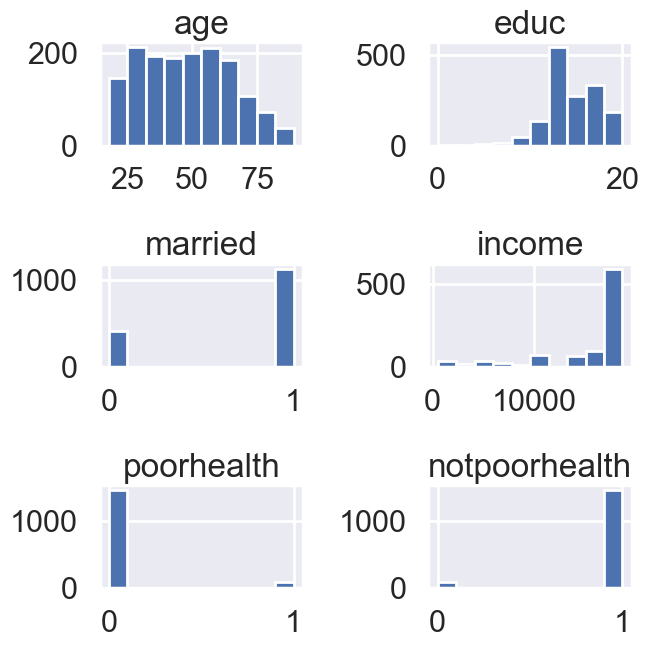

In [89]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS

gssdata.hist(figsize=(7,7))
plt.tight_layout()



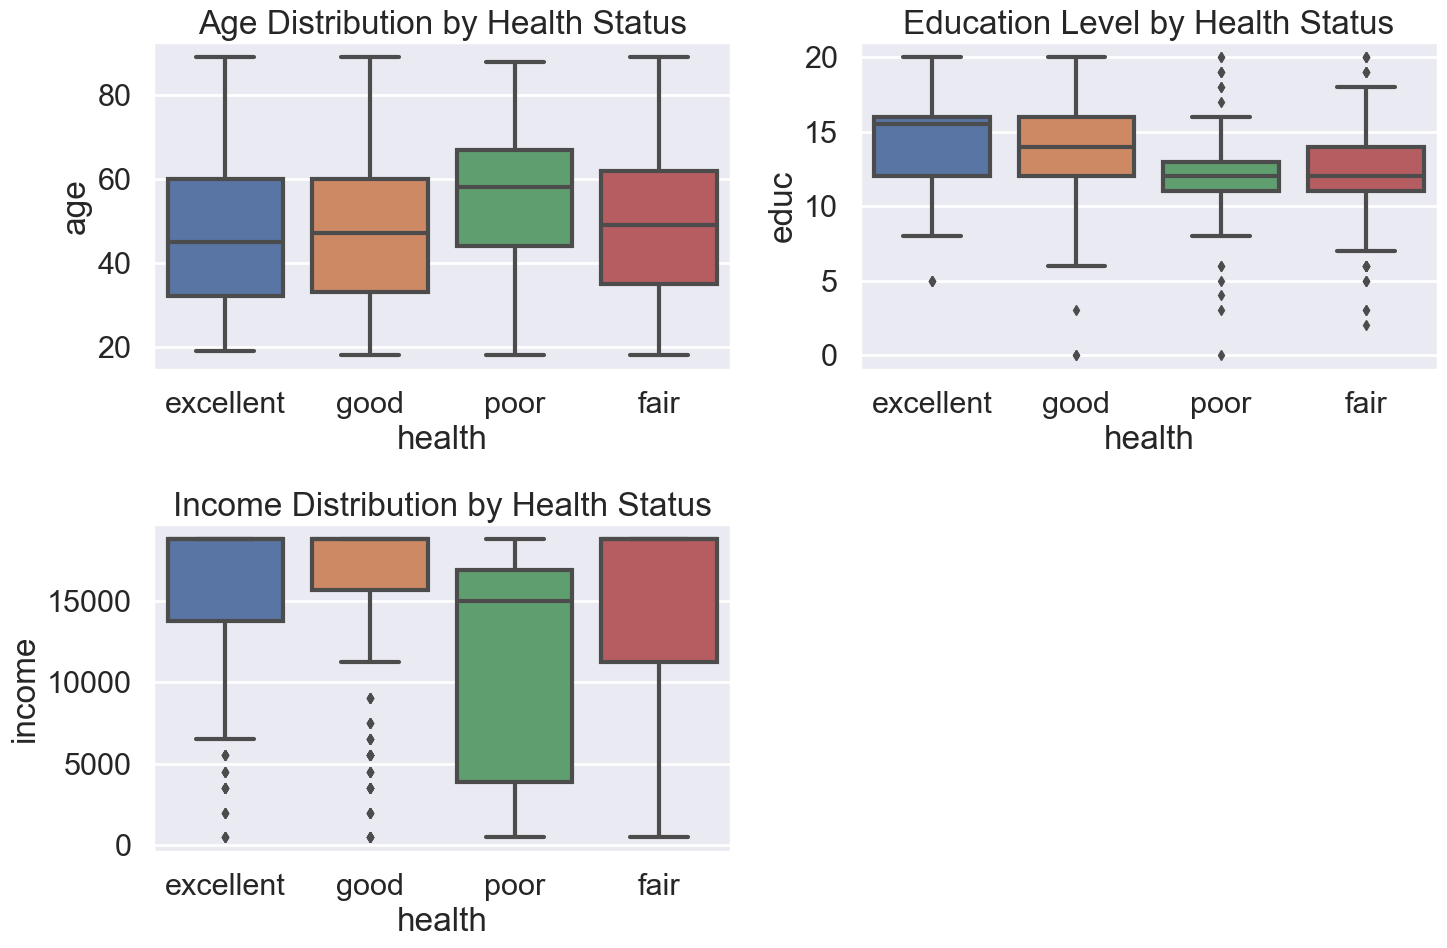

In [90]:
plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
sns.boxplot(x='health', y='age', data=gssdata)
plt.title('Age Distribution by Health Status')

plt.subplot(2, 2, 2)
sns.boxplot(x='health', y='educ', data=gssdata)
plt.title('Education Level by Health Status')

plt.subplot(2, 2, 3)
sns.boxplot(x='health', y='income', data=gssdata)
plt.title('Income Distribution by Health Status')

plt.tight_layout()

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [91]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [92]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()
#print(gssdata.columns)

(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,False,True,False,False,True,False,False,False,True


### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.

In [93]:
######HERE YOUR CODE TO FIT THE MODEL
######
######
######Look up LogisticRegression() from scikitlearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


features = ['age', 'female', 'educ', 'married', 
           'sexornt_bisexual', 'sexornt_dont know', 'sexornt_heterosexual or straight',
           'sexornt_homosexual or gay', 'partyid_dem', 'partyid_other', 'partyid_rep', 'race_black', 'race_other', 'race_white']

X = gssdata[features]
y = gssdata['poorhealth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Training Accuracy: 0.941
Test Accuracy: 0.920
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[286   0]
 [ 25   0]]


/Users/ulasawczuk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ulasawczuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Your answer goes here**

---
We got a training accuracy of approximately 94.1% and a test accuracy of approxiamtely 92%, but our precision, recall and F1-score are all 0:(((. Also we can see that we have 286 True Negatives and 25 False Negatives. So we know exactly what has happened. Our model classified everything as the negative class, being biased towards it as it had way more instances present the the positive class. We see why accuracy alone is not a good metric and can be misleading.

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

Initial sample size: 1551
Final sample size after dropping missing values: 963
Total dropped observations: 588
Poor health cases before cleaning: 99
Poor health cases after cleaning: 16


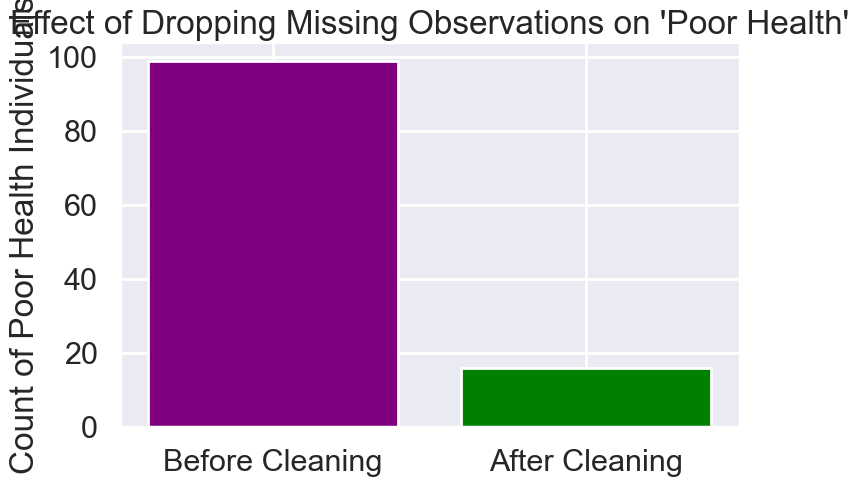

In [94]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.

#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

# gssdata_full #<---this should be your final data frame.

initial_count = len(gssdata)

gssdata_full = gssdata.dropna()

final_count = len(gssdata_full)
dropped_count = initial_count - final_count

print(f"Initial sample size: {initial_count}")
print(f"Final sample size after dropping missing values: {final_count}")
print(f"Total dropped observations: {dropped_count}")

# compare poorhelth
poorhealth_before = gssdata['poorhealth'].sum()
poorhealth_after = gssdata_full['poorhealth'].sum()

print(f"Poor health cases before cleaning: {poorhealth_before}")
print(f"Poor health cases after cleaning: {poorhealth_after}")

plt.figure(figsize=(8, 5))
plt.bar(["Before Cleaning", "After Cleaning"], [poorhealth_before, poorhealth_after], color=['purple', 'green'])
plt.ylabel("Count of Poor Health Individuals")
plt.title("Effect of Dropping Missing Observations on 'Poor Health'")
plt.show()


In [95]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

**Your answer goes here**

In total we removed 588 samples from the total amount when deleting the rows with NAN values. In this we have 83 'poorhealth' samples, which made them drop from 99 to 16 instances. This is almost 83% of all of them which is a lot and makes our dataset even more imbalanced with now a ratio of rouglhy 1:59 (poorhealth:notpoorhealth).

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [96]:
from sklearn.metrics import accuracy_score

#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################


#logit1
#<-- this should be the name of your model so as to work below with the confusion matrix 
      #(or if you have a different name, then change it there as well)

logit1 = LogisticRegression(C=1000000, random_state=42)
logit1.fit(X_train, y_train)


y_test_pred = logit1.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy:.3f}")

print(y_test.value_counts())



Test set accuracy: 0.988
poorhealth
0    238
1      3
Name: count, dtype: int64


**Your answer goes here**

Our accuracy is higher then before, now 98.8%. However in our test set we have 3 instances of the positive class which make up roughly 1.2% of the whole test set (241 instances in total). Thus, if our Logistic Regression model would be classifying everythig as the negative class (which I think is happening tbh) our accuracy would be exactly 98.8% (the same!!!).

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [97]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit1.predict(X_test)))

[[238   0]
 [  3   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [98]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [99]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit1, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[228  10]
 [  2   1]]
[[684  25]
 [ 12   1]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [100]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

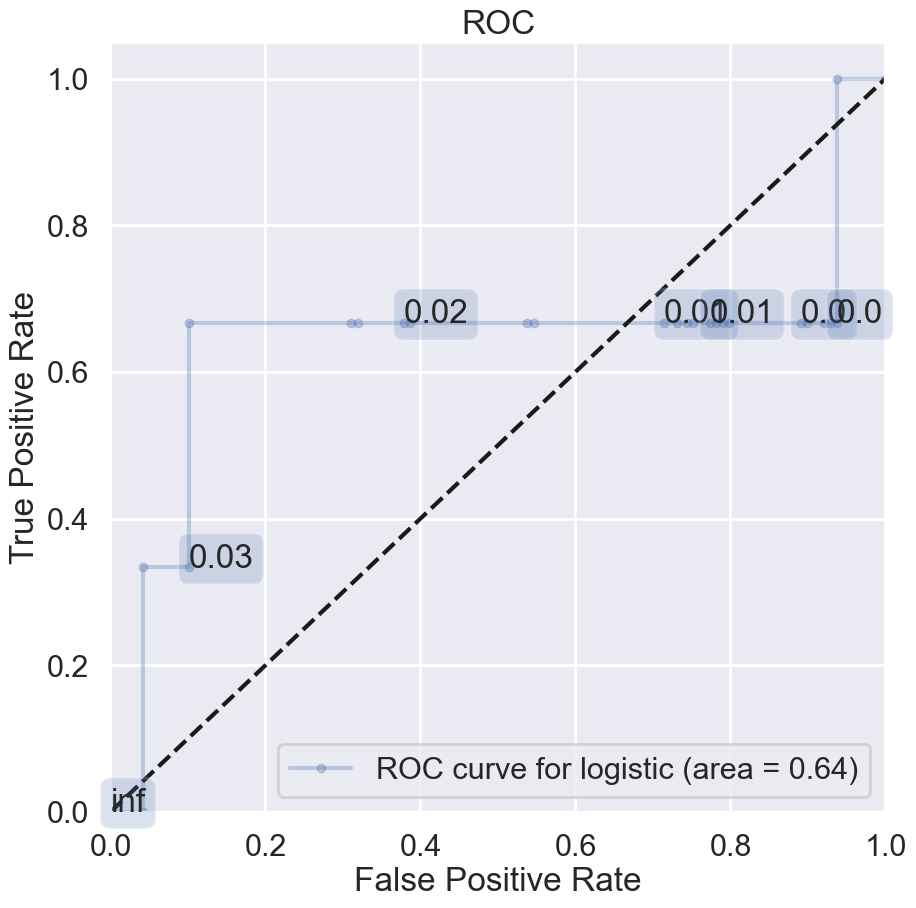

In [101]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit1, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**Your answer goes here**

The area that we get from our ROC curve is pretty low, only 0.58 very close to random, when we should strive for 1. It is also very step-like, stays close to the diagonal line and we have few threshold points, this all tells us that our model fails to differeniate correctly between two classees, also it is often predicting low probabilities because of the majority of one class. We aslo do not have any sweet spot where our model performs well, it struggles to balance between True Positives and False Positives. This all is happening because of the imbalance in our data, our model cannot perform well.

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

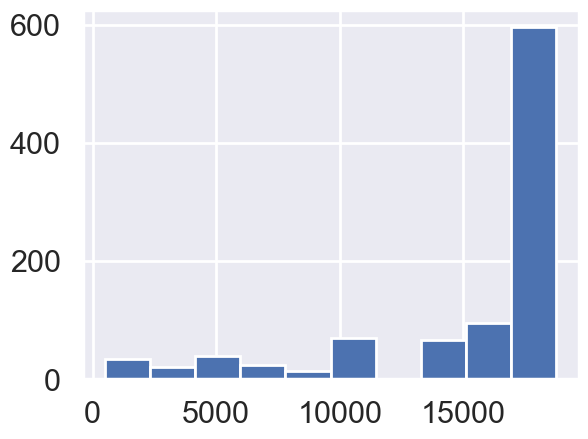

In [102]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

15633.177570093458


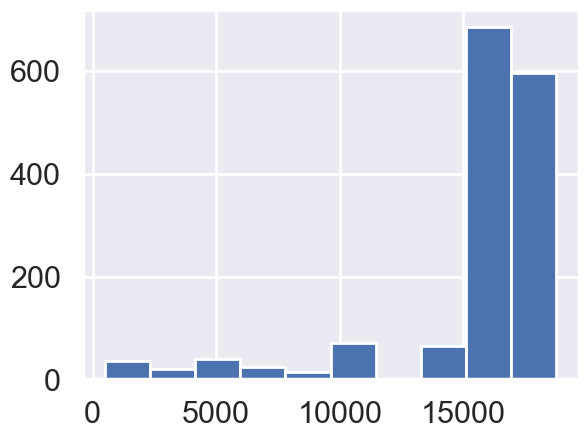

In [103]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
###YOUR CODE HERE
###
###

gssdata_imputed = gssdata.copy()
income_mean = gssdata['income'].mean() # get the mean
gssdata_imputed['income'] = gssdata_imputed['income'].fillna(income_mean)


print(income_mean)

hist = plt.hist(gssdata_imputed['income'])
      

In [ ]:
###here, do a proper train/test split and a model training

X_imputed = gssdata_imputed[['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'income']]
y_imputed = gssdata_imputed['poorhealth']

# I use the same train, test split for fairness and good comaprison
X_train_imp = X_imputed.iloc[itrain, :]
X_test_imp = X_imputed.iloc[itest, :]
y_train_imp = y_imputed.iloc[itrain]
y_test_imp = y_imputed.iloc[itest]

logit2 = LogisticRegression(C=1000000, random_state=42)
logit2.fit(X_train_imp, y_train_imp)

y_pred_imp = logit2.predict(X_test_imp)
test_accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)

print(f"Test set accuracy: {test_accuracy_imp:.3f}")



Test set accuracy: 0.929


In [ ]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################
print("test 0.1")
print(confusion_matrix(y_test_imp,t_repredict(logit2, 0.1, X_test_imp)))
print("test 0.2")
print(confusion_matrix(y_test_imp,t_repredict(logit2, 0.2, X_test_imp)))
print("test 0.3")
print(confusion_matrix(y_test_imp,t_repredict(logit2, 0.3, X_test_imp)))
print("test 0.4")
print(confusion_matrix(y_test_imp,t_repredict(logit2, 0.4, X_test_imp)))

print("train 0.1")
print(confusion_matrix(y_train_imp,t_repredict(logit2, 0.1, X_train_imp)))
print("train 0.2")
print(confusion_matrix(y_train_imp,t_repredict(logit2, 0.2, X_train_imp)))
print("train 0.3")
print(confusion_matrix(y_train_imp,t_repredict(logit2, 0.3, X_train_imp)))

test 0.1
[[194  30]
 [  9   8]]
test 0.2
[[221   3]
 [ 16   1]]
test 0.3
[[224   0]
 [ 17   0]]
test 0.4
[[224   0]
 [ 17   0]]
train 0.1
[[573 105]
 [ 26  18]]
train 0.2
[[656  22]
 [ 40   4]]
train 0.3
[[672   6]
 [ 43   1]]


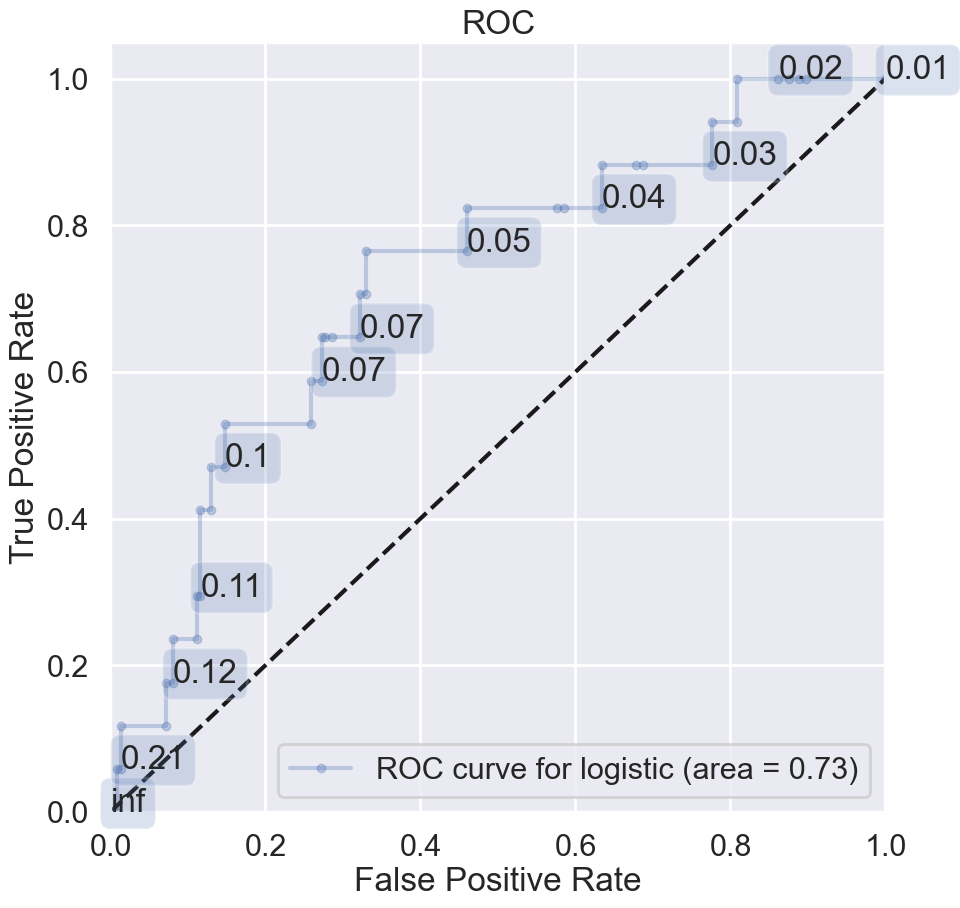

In [ ]:
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit2, y_test_imp, X_test_imp, labe=4, skip=0)
plt.show()

### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

Our ROC curve improved form 0.58 to 0.70, and it is more consistently above the diagonal line. The fact that we have more threshold points indicates a better probability spread. Also expewrimenting with different thresholds for the confusion matrices we see better performance with higher thresholds than before, on 0.4 we already manage to classify one positive instance correctly in the test set. Our model still shows some imbalance issues but less severe than before. However filling the missing values with the mean might not have been the best idea as they contribute to about 80% of our positive class so a big part of individuals there have an average income which might bias the model, we might also be overestimating the relationshipt between income and health this way.

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [113]:
predicted_income = 0

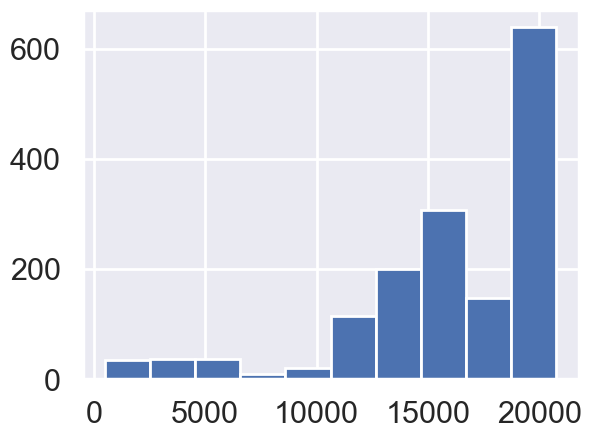

In [114]:
#use the dataset without NAs here
#train a model

#####################
# your code here: 
from sklearn.linear_model import LinearRegression

gssdata_lin = gssdata.copy()
missing = gssdata_lin['income'].isnull()

train_data = gssdata_full  # rows where 'income' is NOT missing
X_train = train_data[features]
y_train = train_data['income']

lr = LinearRegression()
lr.fit(X_train, y_train)


# find rows with missing income 
X_missing = gssdata_lin.loc[missing, features]  
if not X_missing.empty:
    predicted_income1 = lr.predict(X_missing)  # predict missing values
    predicted_income = predicted_income1
    gssdata_lin.loc[missing, 'income'] = predicted_income

hist = plt.hist(gssdata_lin['income'])

#####################

Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [ ]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata[gssdata['income'].isnull()].index
missing_series = pd.Series(data=predicted_income, index=missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp.loc[missing_index, 'income'] = missing_series

# I have already done it above by my own so I am leaving both versions

count     1551.000000
mean     15639.176242
std       4198.095577
min        500.000000
25%      13795.277226
50%      16846.960246
75%      18750.000000
max      20754.389053
Name: income, dtype: float64

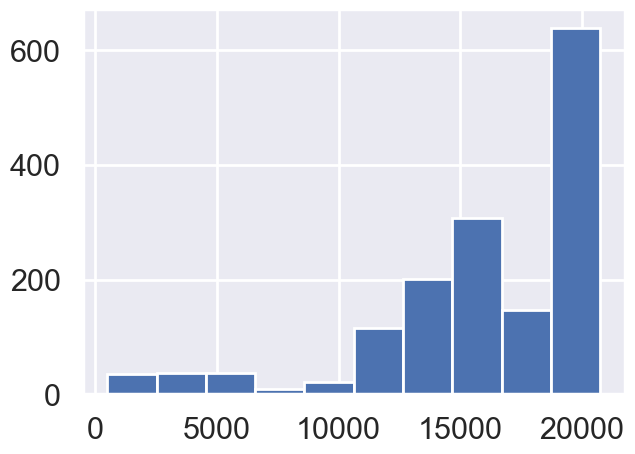

In [116]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [ ]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)
###here, do a proper train/test split and a model training

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

In [117]:
#here you fit a model
#should be called logit3

X_imputed = gssdata_imp[['age', 'educ', 'female', 'partyid_dem', 'partyid_rep', 'income']]
y_imputed = gssdata_imp['poorhealth']

# I use the same train, test split for fairness and good comaprison
X_train_imp = X_imputed.iloc[itrain, :]
X_test_imp = X_imputed.iloc[itest, :]
y_train_imp = y_imputed.iloc[itrain]
y_test_imp = y_imputed.iloc[itest]

logit3 = LogisticRegression(C=1000000, random_state=42)
logit3.fit(X_train_imp, y_train_imp)

y_pred_imp = logit3.predict(X_test_imp)
test_accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)

print(f"Test set accuracy: {test_accuracy_imp:.3f}")

Test set accuracy: 0.929


test 0.1
[[192  32]
 [  8   9]]
test 0.2
[[221   3]
 [ 15   2]]
test 0.3
[[223   1]
 [ 17   0]]
test 0.4
[[224   0]
 [ 17   0]]
train 0.1
[[573 105]
 [ 25  19]]
train 0.2
[[653  25]
 [ 39   5]]
train 0.3
[[672   6]
 [ 42   2]]


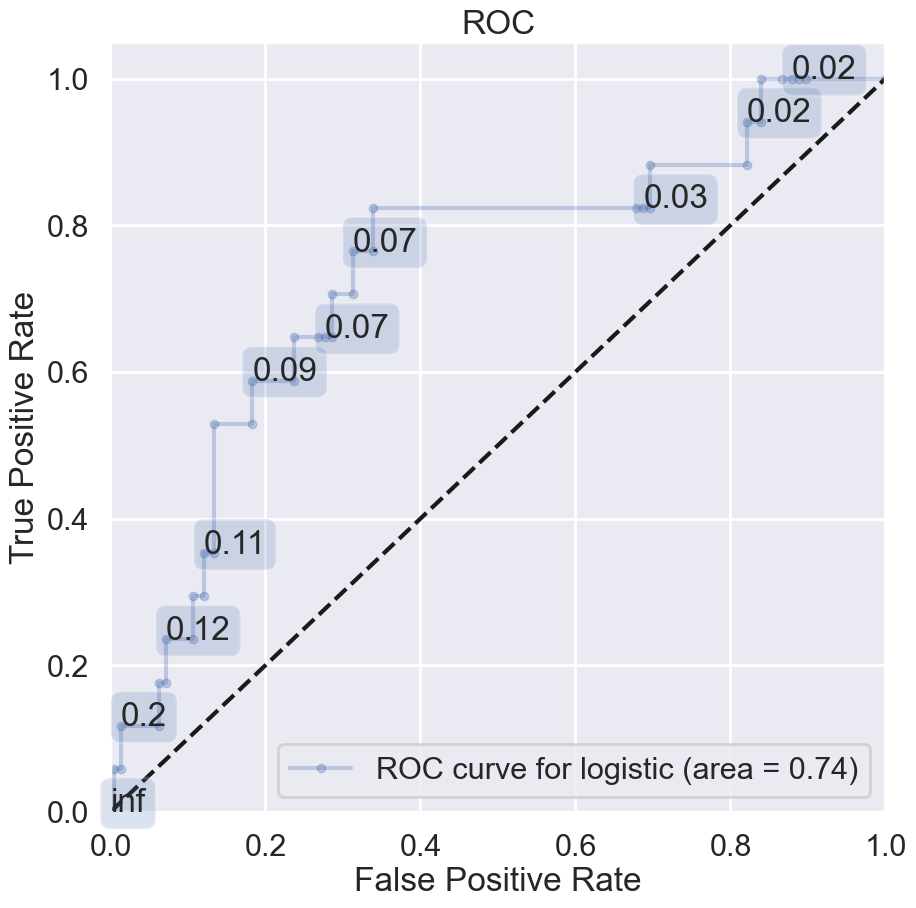

In [118]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE
#####################
# your code here: create an ROC curve
#####################

print("test 0.1")
print(confusion_matrix(y_test_imp,t_repredict(logit3, 0.1, X_test_imp)))
print("test 0.2")
print(confusion_matrix(y_test_imp,t_repredict(logit3, 0.2, X_test_imp)))
print("test 0.3")
print(confusion_matrix(y_test_imp,t_repredict(logit3, 0.3, X_test_imp)))
print("test 0.4")
print(confusion_matrix(y_test_imp,t_repredict(logit3, 0.4, X_test_imp)))

print("train 0.1")
print(confusion_matrix(y_train_imp,t_repredict(logit3, 0.1, X_train_imp)))
print("train 0.2")
print(confusion_matrix(y_train_imp,t_repredict(logit3, 0.2, X_train_imp)))
print("train 0.3")
print(confusion_matrix(y_train_imp,t_repredict(logit3, 0.3, X_train_imp)))

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit3, y_test_imp, X_test_imp, labe=4, skip=0)
plt.show()

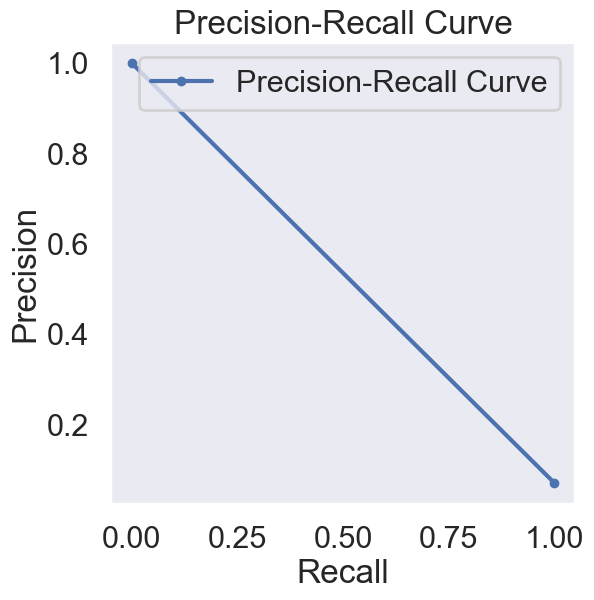

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_imp, y_pred_imp)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**

The model using imputation woiht predicting the value has the best ROC curve with area 0.74. Just deleting the rows with missing values gave us the worst performance which makes sense as by dropping the rows we can lose valuable information. Also in our case it just made our data set more imbalanced, which was kind of worst case scenario. Filling the missing values with the mean was a better approach and gave us a ore reasonable curve shape. However, it artificially reduces variance and creates clusters at the mean value. It is a better choice for us because of already very ibalanced dataset with 1:15 classes ratio while the deletion made it increase to 1:59 classes ratio which is a bit crazy. Our last approach gave us the best performance. The prediction method takes advanatage of the correlation between variables giving us infomred predicted values. On the ROC curve we can see even more threshold points than before meaning our probability distribution is better. <br>
Still we could take a look at Precision-Recall curve to gain better insight as the ROC curve might still be a bit misleading. Looking at the precision-recall curve above for the moel using imputation by predicting values, we see that we actually have bad performance with still labeling all the positivie instances as negative.

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

For this question, you are also free (but not onbliged) to use techniques to address class imbalances (as we discussed in class) both on the data or model level. Recall that each method has advantages and disadvantages, so you will need to correctly interpret the results and assess the performance of any method you choose on the problem we explore here. Some examples can be found [here](https://imbalanced-learn.org/stable/index.html). 

In [ ]:
## your code goes here